## Introduction to Gaussian Processes and GP Regression

In this notebook you will get to explore Gaussian Processes with different mean and kernel functions, how they can be used for predictions, as well as how we can learn kernel functions.

In [ ]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime
import time

%pip install gpflow # Only need to run once per session
import gpflow
from gpflow.mean_functions import MeanFunction
from gpflow.utilities import set_trainable
from gpflow.utilities import print_summary
gpflow.config.set_default_float(np.float64)



# Sample from GPs

First, you will simply sample from Gaussian Processes without considering any data. This is just to get familiar with the effects of changing the mean and kernel functions. The mean function has no restrictions so feel free to get creative. You can find some kernel functions and their parameters here:

https://gpflow.github.io/GPflow/2.9.0/notebooks/getting_started/kernels.html
https://gpflow.github.io/GPflow/2.9.0/api/gpflow/kernels/index.html

For more creative examples see here:

https://raw.githubusercontent.com/duvenaud/phd-thesis/master/kernels.pdf

And if you're curious about how these samples are created, see section 2.5 here (and google Cholesky decomposition):

https://folk.ntnu.no/joeid/GPnote.pdf



In [ ]:
# @title
kernels = [
    """
    You should add your own
    """
]

class CustomMeanFunction(MeanFunction):
    def __init__(self):
      return
    def __call__(self, X):
      """
      Try changing the mean function. Note: Needs to be 2D, might need to add .reshape(-1,1)
      """
      return np.sin(X)



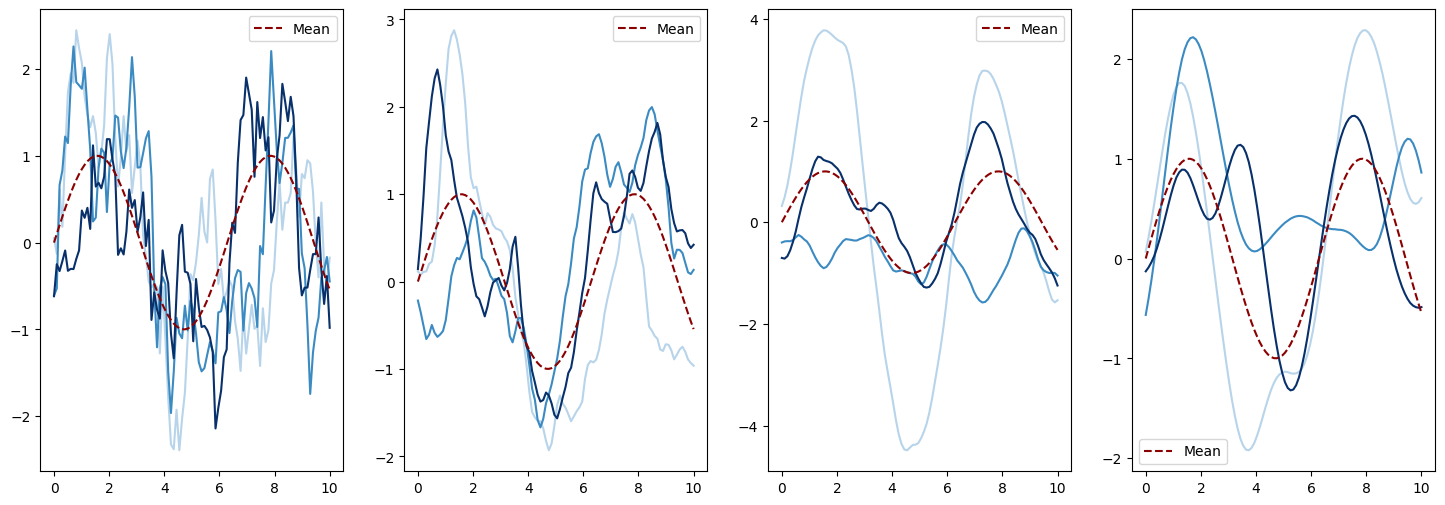

In [ ]:
# @title
num_samples = 3 # Feel free to change

#Plotting
plt.figure(figsize=(18, 6))
colors = plt.cm.Blues(np.linspace(0.3, 1, num_samples))

for i in range(len(kernels)):

    #Instantiating the GP
    kernel = kernels[i]
    m = gpflow.models.GPR(data=(np.array([[0.]]), np.array([[0.]])), kernel=kernel, mean_function=CustomMeanFunction())

    #You can change the prediction domain if you want
    X = np.linspace(0, 10, 100).reshape(-1, 1)
    samples = m.predict_f_samples(X, num_samples)

    #Just plotting
    plt.subplot(1, len(kernels), i+1)
    for j in range(num_samples):
        plt.plot(X, samples[j, :, 0], color=colors[j])
    plt.plot(X,CustomMeanFunction().__call__(X), color = "darkred",linestyle='--', label='Mean')
    plt.legend()

plt.show()

**Some things to answer**

What are the behaviors of some different kernels? For example, which are smooth and which are jagged? What does changing the kernel variance do? What is the effect of multiplying kernels, for example Linear*RBF?

# Building your own GP Regression model

We will now get a little under the hood to understand how a GP with a predefined mean and kernel function can run inference and prediction. The problem here is to implement a simple GPR class for inference. For the formula for the predicted mean and variance at the prediction points, see equation 7 here:

https://mlg.eng.cam.ac.uk/pub/pdf/Ras04.pdf

(Although you probably have to start reading a bit above to see what the different parts of the formula are)

In [ ]:
class GPRegressor():
  def __init__(self, kernel, mean):
    """
    Instantiate with the needed input. Set defaults if you want
    """


  def predict(self, target, data):
    """
    Function that takes in x-values where we are interested in predicting f(x),
    as well as data containing observed values of f(x). You may encode these as you want
    Output should be mean_pred, var_pred
    """

In [ ]:
"""
Example use. You may choose another implementation in terms of how numbers/vectors/matrices are set up and treated
You may for example have the kernel take in numbers instead of matrices
"""

def zero_mean(X):
  return np.zeros(X.shape)

#Using this kernel implicitly adds the point (0,0) the observed data
def brownian_kernel(X1,X2):
  return np.minimum(X1, X2.T)

GPR = GPRegressor(kernel = brownian_kernel, mean = zero_mean)

"""
This is just sample data, feel free to change
How does the model tackle different types of data? For example, what happens if you scale all the y-values?
"""
n_points = 5
X = np.linspace(0+1e-4,1,n_points).reshape(-1,)
data = np.hstack((X,np.sin(X))).reshape(n_points,2)

#Should not contain the exact values where you are predicting, unless you make your implementation handle this
#Bonus: What can you say about the covariance martix whenever this happens?
x_predict = np.linspace(1e-3,1-1e-3,100).reshape(100,1)

mean_pred, var_pred = GPR.predict(x_predict, data)

plt.plot(data[:,0],data[:,1],marker="o", markerfacecolor = "black",markeredgecolor = "black", label = "Observed data",linestyle='')
plt.plot(x_predict, mean_pred, color = "darkred", label='Mean')
plt.plot(x_predict, mean_pred + 1.96*var_pred, color = "blue", label='Upper confidence interval')
plt.plot(x_predict, mean_pred - 1.96*var_pred, color = "blue", label='Lower confidence interval')
plt.fill_between(x_predict.reshape(-1,), (mean_pred - 1.96*var_pred).reshape(-1,), (mean_pred + 1.96*var_pred).reshape(-1,), alpha = 0.15)
plt.legend()
plt.show()

# Using an optimizer to find the parameters of the kernel

We will now go over to using gpflow since it is faster and has some nice built-in functions. In particular, we can easily optimize the parameters of the kernel, which gpflow does by cross vaidation.

The loss function used is the likelihood of the observed data. For example, if the variance is too low then the points far from the mean (=zero) are very unlikely, so this is suboptimal. On the other hand, if the variance is too high then a lot of points are kinda likely but no points have a high likelyhood (including the data), so this is also suboptimal. The optimal variance is somewhere in the middle.

If you want to verify that your model is acting correctly, you can chwck if the behavior is similar to the one here:

http://www.infinitecuriosity.org/vizgp/

In [ ]:
"""
Here is one example of a function to optimize, but
feel free to experiment around. When does the optimization not work well?
"""
def unknown_function(X):
  def d1(X):
    a1 = np.sin(X)
    a2 = (1+X/10)
    b1 = np.cos(2*np.sin(X))
    b2 = np.cos(15*X + X**2/50)/20
    c1 = np.exp(X/25)
    return (a1*a2 + b1 + b2)*c1
  return d1(X) + d1(X-4)/1.5 + np.sin(X)/4

In [ ]:
"""
For adding a new point. You might need to change this if you use a different "unknown" function
"""
def observe_new_data(X_obs, Y_obs, next_X):
   X_obs = np.append(X_obs, [[next_X]]).reshape(-1, 1)
   Y_obs = np.append(Y_obs, [[unknown_function(next_X)]]).reshape(-1, 1)
   return X_obs, Y_obs


In [ ]:
# For prediction and plotting
min_x = 0
max_x = 12

# Number of new observations
num_samples = 1

"""
Add your favourite kernel here
"""
kernel = None

"""
Experiment with changing this as well as the "unknown" function above
"""
X_obs = np.array([1.0,3.0,7.0]).reshape(-1,1) # Some initial data points. Free to change
Y_obs = unknown_function(X_obs)

# We can optimize the function in a stepwise manner, iteratively predicting and then chossing the next point to observe
for i in range(num_samples):

  model = gpflow.models.GPR(data=(X_obs, Y_obs), kernel=kernel) # mean is zero by default
  model.likelihood.variance.assign(1e-6) # So that the model knows the observed values coincide with the true function

  # Optimize the parameters of the kernel
  optimizer = gpflow.optimizers.Scipy()
  optimizer.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))

  # Make a prediction
  X_pred = np.linspace(min_x, max_x, 100).reshape(-1, 1)
  mean_pred, var_pred = model.predict_f(X_pred)

  # plotting
  plt.figure(figsize=(18, 6))
  plt.plot(X_pred, unknown_function(X_pred), color = "darkred", lw=2, label='True function')
  plt.scatter(X_obs, Y_obs, c='black', zorder=10, label='Observations')
  plt.plot(X_pred, mean_pred, 'b-', lw=2, label='GP Mean')
  plt.fill_between(X_pred[:, 0],
                  mean_pred[:, 0] - 1.96 * np.sqrt(var_pred[:, 0]),
                  mean_pred[:, 0] + 1.96 * np.sqrt(var_pred[:, 0]),
                  color='blue', alpha=0.2, label='95% Confidence Interval')
  plt.legend()
  plt.xlabel('X')
  plt.ylabel('f(X)')
  plt.title('GP Inference on Unknown Function')
  plt.show()

  """
  Make a measurement of the unknown function. Make this part smarter.
  """
  next_X = np.random.uniform(min_x,max_x)
  X_obs, Y_obs = observe_new_data(X_obs, Y_obs, next_X)

**Things to explore**

How many samples did you need before you found a good solution?

In what situations might this be better than gradient-based or grid search methods?

For what kinds of unknown functions does this not work?

# Learning the kernel function itself

Lastly, we will (kind of) tackle a notoriously hard problem: Predicting future stock prices. For this, we will still use a GPR, but this time we will combine it with other ML methods to learn the kernel function itself.

Yes, to do this we will need to make the model "more" parametric, but even with relatively few parameters we are able to build a very flexible model that can learn intricate patterns based on little data.

Your task here is simply to run the code and make sure you understand the various components. Also feel free to improve the model by adding more kernels or other changes. This model is in no way perfect.

In [ ]:
ticker = "^SPX"

n_points = 50 # number of data points to actually use. We will pretend like these are the only observations we have

D = yf.download(ticker, start="2000-01-01", end="2023-12-31", interval="1d")["Adj Close"].iloc[::5]
D.index = D.index.map(pd.Timestamp.timestamp)
D = np.log(D) # Taking log to turn geometric growth to arithmetic
D = (D-D.mean())/D.std() # Normalizing to make tuning parameters easier

# Weights here make more recent points more likely
weights = np.linspace(0, 1, len(D)-1)
weights /= weights.sum()

# Ensures the last observation is included
selected_indices = np.append(np.random.choice(D.index[:-1], size=n_points-1, replace=False,p=weights), D.index[-1])

selected_values = D.loc[selected_indices]
data = pd.DataFrame()
data["y"] = pd.DataFrame(selected_values)

plt.figure(figsize=(18, 6))
plt.plot(D.index, D, label='Actual time series')
plt.scatter(selected_indices, data["y"], color='darkred', label='Observed points',zorder = 10)
plt.title("S&P500 index over time")
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

**Define model parameters**

First we define the hyper-parameters of the model, which tune the learning algorithm. Feel free to change these around

In [ ]:
"""
These hyperparameter values are not ideal for getting credible prediction intervals. Can you improve?
"""
regularization_weight = 5.0 #L1 coefficient on the weights of the function. If this is higher, the model will choose fewer unique kernels from the list
clip_value = 1e-5 #To avoid getting NaN values from too high gradients. If this is too low the model will learn very slowly
noise_variance = 1e-5 #Precision of the knowledge of the observed data. In this case we are very certain
init_learning_rate = 1e-1 #Initial learning rate
learning_rate_decay_rate = 0.98 #Fraction of learning rate decay from one epoch to the next
num_epochs = 100 #Number of epochs. In this case an epoch results in one update of the model parameters
init_var = data.values.var() #initial variance of the kernels
init_length = 1e-2 #initial length scale of the kernels. This will also be tuned during optimization
"""
Here you are free to buid as wonky kernels as you want
"""
kernels = [
    gpflow.kernels.RBF(variance = init_var, lengthscales = init_length),
    gpflow.kernels.Linear(),
    gpflow.kernels.Linear()*gpflow.kernels.Linear(),
]


**Setting up a custom kernel**

The kernel here is a weighted sum of multiple kernels. The weights are then L1 regularized to incentivise the model to only use a subset of the kernels

In [ ]:
class WeightedSumKernels(gpflow.kernels.Combination):
  def __init__(self, kernels, weights):
      super().__init__(kernels)
      self.weights = weights

  def K(self, X, X2=None):
      result = 0.0
      for weight, kernel in zip(self.weights, self.kernels):
          result += weight * kernel.K(X, X2)
      return result

  def K_diag(self, X):
      result = 0.0
      for weight, kernel in zip(self.weights, self.kernels):
          result += weight * kernel.K_diag(X)
      return result

for kernel in kernels:
  try:
    set_trainable(kernel.variance, False)
  except AttributeError:
    pass

#Define trainable weights for all the kernel
weights = [tf.Variable(1/len(kernels)**2, dtype=tf.float64, trainable=True) for _ in kernels]

#Build the custom combined kernel
combined_kernel = WeightedSumKernels(kernels=kernels, weights=weights)

**Set up optimizer**

Learning rate is set to decrease over time to help the model converge

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=init_learning_rate,
    decay_steps=num_epochs,
    decay_rate=learning_rate_decay_rate,
    staircase=True)
optimizer = tf.optimizers.Adam(learning_rate=lr_schedule)

**Define the optimization step**

Here we define the loss as the sum of model loss and regularization loss. This part can be modified to bias the model towards the type of kernels you want. Here we could also add a term if we had any trainable variables included there

In [ ]:
def optimization_step(optimizer, model, regularization_weight):
  with tf.GradientTape() as tape:
    model_loss = model.training_loss()
    regularization_loss = regularization_weight * tf.reduce_sum([tf.math.abs(weight) for weight in weights])
    total_loss = model_loss + regularization_loss
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return model_loss.numpy()

**Set up the data arrays for training**

Notice the dimensions

In [ ]:
time = selected_indices.reshape(-1, 1) # Time features need to be 2D for GPflow
time = (time-time.min())/(time.max()-time.min())
y_values = np.array(data).reshape(-1, 1)
combined = np.hstack((time, y_values))

#Sorting in order of time. Doesn't really matter for the model but plotting is nicer
sorted_combined = combined[combined[:,0].argsort()]

time = sorted_combined[:, 0].reshape(-1, 1)
data = sorted_combined[:, 1].reshape(-1, 1)

**Train the model**

Actually training the model does not take many lines

In [ ]:
model = gpflow.models.GPR(data=(time, data), kernel=combined_kernel)
model.likelihood.variance.assign(noise_variance)

losses = []

for epoch in range(num_epochs):
    loss = optimization_step(optimizer, model, regularization_weight)
    losses.append(loss)
    if epoch%10==0:
      print(f"Epoch: {epoch:3d}  |  Loss: {loss:12.4f}")
print(f"Final Loss: {losses[-1]:12.4f}")

**Predict and evaluate the model**

Here are some output plots and data. How do you interpret the kernel weights?

In [ ]:
# Make and plot predictions
time_pred = np.linspace(1, 1.1, 1000).reshape(-1, 1)  # Future time steps
mean_pred, var_pred = model.predict_f(time_pred)

plt.figure(figsize=(12, 6))
plt.plot(time, data, label='Data', alpha=0.5)
plt.plot(time_pred, mean_pred, 'b', label='Prediction')
plt.fill_between(time_pred[:, 0], mean_pred[:, 0] - 0.67*np.sqrt(var_pred[:, 0]), mean_pred[:, 0] + 0.67*np.sqrt(var_pred[:, 0]), color='blue', alpha=0.2, label = "50% confidence")
plt.legend()
plt.show()

#Loss by epoch
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Iterations')
plt.legend()
plt.show()

#Here are the kernel weights
for weight,kernel in zip(weights,kernels):
  print(f"Weight: {weight.numpy():.3f} | Kernel: {str(kernel.__class__.__name__)}")

**Discussion**

Do the predictions seem reasonable? Would you invest based on this?

How few data points can you use before the model becomes completely unreliable?

How do the weights behave when you have many different kernels? How are they affected by changing regularization_weight?